In [2]:
include("./proxgrad.jl")

proxgrad_const (generic function with 1 method)

In [3]:
using DataFrames
using GZip

##possible types in arff files are:
#real, numeric,
#date
#string
#nominal specifications, starting with {

function convertType(attrType)
  x = lowercase(attrType)
  res = nothing
    
  if in(x, ["real" "numeric"])
    res = "numeric"
  elseif startswith(x, "{")
    res = "nominal"
  else #date and string
    res = x
  end
  return(res)
end

function readArff(filename, gzip=false)
  f = nothing
  if gzip
    f = GZip.gzopen(filename)
  else
    f = open(filename)
  end
  lines = eachline(f)
    
  header = true
  colNames = nothing
  attrTypes = nothing
  myData = DataFrame()
  attributes = DataFrame()
  nAttr = 0
  nData = 0

  for l in lines
    if header
      mAttr = match(r"^[[:space:]]*@(?i)attribute", l)
      if mAttr == nothing
        mData = ismatch(r"^[[:space:]]*@(?i)data", l)
        if mData
          colNames = convert(Array, attributes[2,:])
          attrTypes = map(convertType, convert(Array, attributes[3,:]))
          header=false
          break
        end
      else
        nAttr += 1
        attributes[:, nAttr] = split(l)[1:3]
      end
    end
  end
  myData = readtable(f, names = vec(map(Symbol, colNames)))
  close(f)
  return(myData, attrTypes)
end

readArff (generic function with 2 methods)

In [4]:
dataset1, attributeTypes1 = readArff("Mohammad14JulyDS_1.arff");

In [5]:
dataset2, attributeTypes2 = readArff("Mohammad14JulyDS_2.arff");

In [6]:
dataset = vcat(dataset1, dataset2);

In [7]:
dataset = dataset[shuffle(1:end),:];

In [8]:
names(dataset)

32-element Array{Symbol,1}:
 :having_IP_Address          
 :URL_Length                 
 :Shortining_Service         
 :having_At_Symbol           
 :double_slash_redirecting   
 :Prefix_Suffix              
 :having_Sub_Domain          
 :SSLfinal_State             
 :Domain_registeration_length
 :Favicon                    
 :port                       
 :HTTPS_token                
 :Request_URL                
 ⋮                           
 :RightClick                 
 :popUpWidnow                
 :Iframe                     
 :age_of_domain              
 :DNSRecord                  
 :web_traffic                
 :Page_Rank                  
 :Google_Index               
 :Links_pointing_to_page     
 :Statistical_report         
 :Result                     
 :DNS                        

In [9]:
# X = dataset[:, filter(x -> x != :Result, names(dataset))]
# [X[isna.(X[nm]), nm] =  0  for nm in names(X)]
# X = Array(X)

X = dataset[:, filter(x -> x != :Result, names(dataset))]
for nm in names(X)
    count = zeros(3)
    for entry in X[nm]
        if !isna.(entry)
            count[entry+2] += 1
        end
    end
    X[isna.(X[nm]), nm] = maximum(count)-2
    
end
X = Array(X)
y = convert(Array, dataset[:Result]);

In [10]:
y = convert(Array,dataset[:Result]);

In [11]:
Xtrain = X[1:4000,:]
Xtest = X[4001:end,:]
ytrain = y[1:4000]
ytest = y[4001:end];

In [12]:
using ScikitLearn: fit!, predict

In [13]:
Pkg.add("DecisionTree")

using ScikitLearn
using PyCall
using PyPlot
using ScikitLearn.CrossValidation: train_test_split
using DecisionTree

#using ScikitLearn.Models: DecisionTreeClassifier, RandomForestClassifier, AdaBoostStumpClassifier
@pyimport matplotlib.colors as mplc
@sk_import preprocessing: StandardScaler
@sk_import neighbors: KNeighborsClassifier
@sk_import svm: SVC
@sk_import naive_bayes: GaussianNB
@sk_import discriminant_analysis: (LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis)
using ScikitLearn.Utils: meshgrid

INFO: Package DecisionTree is already installed
INFO: METADATA is out-of-date — you may not have the latest version of DecisionTree
INFO: Use `Pkg.update()` to get the latest versions of your packages


In [14]:
@sk_import linear_model: LogisticRegression

PyObject <class 'sklearn.linear_model.logistic.LogisticRegression'>

In [15]:
using ScikitLearn.GridSearch: GridSearchCV
gridsearch = GridSearchCV(LogisticRegression(penalty = "l1"), Dict(:C => 0.1:0.1:2.0))
fit!(gridsearch, Xtest, ytest)
println("Best parameters: $(gridsearch.best_params_)")

Best parameters: Dict{Symbol,Any}(Pair{Symbol,Any}(:C, 0.3))


In [16]:
using ScikitLearn.GridSearch: GridSearchCV
gridsearch = GridSearchCV(LogisticRegression(penalty = "l2"), Dict(:C => 0.1:0.1:2.0))
fit!(gridsearch, Xtest, ytest)
println("Best parameters: $(gridsearch.best_params_)")

Best parameters: Dict{Symbol,Any}(Pair{Symbol,Any}(:C, 0.1))


In [19]:
log = LogisticRegression(C = 0.5, penalty = "l1", fit_intercept=true, max_iter = 100)
fit!(log, Xtrain, ytrain)
#model0 = fit(model, X, y)
ylog = predict(log,Xtest) #the output vector of predictions
accuracy = count(ylog .== ytest)/length(ytest)
#accuracy = sum(predict(log, Xtest) .== ytest) / length(ytest)
#println("accuracy: $accuracy")

log = LogisticRegression(C=0.5, penalty="l1", fit_intercept=true, max_iter=100) = PyObject LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


0.9101423487544484

In [18]:
false_neg = 0 
false_pos = 0 
sum = 0 
for i=1:length(ylog)
    if ytest[i] != ylog[i]
        sum+=1
        if (ytest[i] == 1 && ylog[i] == -1)
            false_neg += 1
        else
            false_pos += 1
        end
    end
end
println(false_neg/length(ylog))
println(false_pos/length(ylog))

0.03825622775800712
0.051601423487544484


In [40]:
log2 = LogisticRegression(C = 0.1, penalty = "l2", fit_intercept=true)
fit!(log2, Xtrain, ytrain)
#model0 = fit(model, X, y)
ylog2 = predict(log2,Xtest) #the output vector of predictions
accuracy = count(ylog .== ytest)/length(ytest)
#accuracy = sum(predict(log, Xtest) .== ytest) / length(ytest)
#println("accuracy: $accuracy")


0.9412811387900356

In [41]:
log

PyObject LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [42]:
false_neg = 0 
false_pos = 0 
for i=1:length(ylog2)
    if ytest[i] != ylog2[i]
        sum+=1
        if (ytest[i] == 1 && ylog2[i] == -1)
            false_neg += 1
        else
            false_pos += 1
        end
    end
end
println(false_neg/length(ylog))
println(false_pos/length(ylog))

0.02491103202846975
0.037366548042704624


In [43]:
#the probabilities of either -1 (first column) or 1 (second column)
p = predict_proba(log, Xtest)

1124×2 Array{Float64,2}:
 0.937485    0.0625149  
 0.998836    0.00116368 
 0.997151    0.00284856 
 0.0223906   0.977609   
 0.993045    0.00695471 
 0.998898    0.00110195 
 0.0781827   0.921817   
 0.816009    0.183991   
 0.999884    0.000115723
 0.959726    0.0402738  
 0.00959297  0.990407   
 0.997912    0.00208752 
 0.0387174   0.961283   
 ⋮                      
 0.018325    0.981675   
 0.889183    0.110817   
 0.347571    0.652429   
 0.998123    0.00187702 
 0.129984    0.870016   
 0.947186    0.0528139  
 0.944962    0.0550384  
 0.98739     0.0126098  
 0.506055    0.493945   
 0.957258    0.0427418  
 0.0242115   0.975788   
 0.0810508   0.918949   

In [44]:
using ScikitLearn.CrossValidation: cross_val_score

@time cv1 = cross_val_score(LogisticRegression(C=0.5, penalty = "l1"), X, y; cv = 10)

  0.991755 seconds (207.28 k allocations: 30.794 MiB, 1.23% gc time)


10-element Array{Float64,1}:
 0.94347 
 0.933723
 0.933723
 0.929825
 0.939571
 0.922027
 0.919922
 0.939453
 0.943249
 0.939335

In [47]:
using StatsBase, StatsFuns, StreamStats
summarystats(cv1)

Summary Stats:
Mean:           0.934430
Minimum:        0.919922
1st Quartile:   0.930799
Median:         0.936529
3rd Quartile:   0.939542
Maximum:        0.943470


In [48]:
@time cv2 = cross_val_score(LogisticRegression(C=0.1, penalty = "l2"), X, y; cv=10)

  0.289632 seconds (4.91 k allocations: 19.380 MiB, 5.04% gc time)


10-element Array{Float64,1}:
 0.94347 
 0.925926
 0.937622
 0.923977
 0.94152 
 0.920078
 0.917969
 0.941406
 0.941292
 0.933464

In [49]:
summarystats(cv2)

Summary Stats:
Mean:           0.932672
Minimum:        0.917969
1st Quartile:   0.924464
Median:         0.935543
3rd Quartile:   0.941378
Maximum:        0.943470


# proximal gradient method 

In [50]:
using LowRankModels

In [51]:
import LowRankModels: evaluate, grad
evaluate(loss::Loss, X::Array{Float64,2}, w, y) = evaluate(loss, X*w, y)
grad(loss::Loss, X::Array{Float64,2}, w, y) = X'*grad(loss, X*w, y)

grad (generic function with 20 methods)

In [68]:
# proximal gradient method
function proxgrad(loss::Loss, reg::Regularizer, X, y;
                  maxiters::Int = 10, stepsize::Number = 1., 
                  ch::ConvergenceHistory = ConvergenceHistory("proxgrad"))
    w = zeros(size(X,2))
    for t=1:maxiters
        t0 = time()
        # gradient step
        g = grad(loss, X, w, y)
        w = w - stepsize*g
        # prox step
        w = prox(reg, w, stepsize)
        # record objective value
        update_ch!(ch, time() - t0, obj = evaluate(loss, X, w, y) + evaluate(reg, w))
    end
    return w
end

proxgrad (generic function with 2 methods)

In [53]:
reg = OneReg()
loss = LogisticLoss()

LowRankModels.LogisticLoss(1.0, LowRankModels.BoolDomain())

In [56]:
y_i = convert(Array{Bool}, ytrain .== 1);

In [57]:
X_i = convert(Array{Float64,2},Xtrain);

In [58]:
step = 1/norm(Xtrain)^2

2.054791804687632e-5

In [64]:
using Plots

ch = ConvergenceHistory("OneReg")
w = proxgrad(loss, reg, X_i, y_i; 
             stepsize=step, maxiters=1000,
             ch = ch)

Plots.plot(ch.objective)
println(w)
println(maximum(abs.(w)))

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] max(::Array{Float64,1}, ::Int64) at ./deprecated.jl:57
 [3] #proxgrad#51(::Int64, ::Float64, ::LowRankModels.ConvergenceHistory, ::Function, ::LowRankModels.LogisticLoss, ::LowRankModels.OneReg, ::Array{Float64,2}, ::Array{Bool,1}) at ./In[52]:12
 [4] (::#kw##proxgrad)(::Array{Any,1}, ::#proxgrad, ::LowRankModels.LogisticLoss, ::LowRankModels.OneReg, ::Array{Float64,2}, ::Array{Bool,1}) at ./<missing>:0
 [5] include_string(::String, ::String) at ./loading.jl:515
 [6] include_string(::Module, ::String, ::String) at /Users/Joshua/.julia/v0.6/Compat/src/Compat.jl:478
 [7] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/Joshua/.julia/v0.6/IJulia/src/execute_request.jl:154
 [8] eventloop(::ZMQ.Socket) at /Users/Joshua/.julia/v0.6/IJulia/src/eventloop.jl:8
 [9] (::IJulia.##14#17)() at ./task.jl:335
while loading In[64], in expression starting on line 5
Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl

[-0.063639, 0.00593467, 0.0526942, -0.533221, -0.15178, 0.983294, 0.673297, 1.51053, -0.159647, 0.143622, -0.153624, -0.114667, -0.238229, 1.38269, 0.288512, -0.0775394, 0.117984, -0.266371, -0.455705, -0.466099, -0.542566, 0.268842, -0.101115, 0.258636, 0.1974, 0.39472, 0.252875, -0.156347, -0.353557, 0.0, 0.330545]
1.5105263093722325



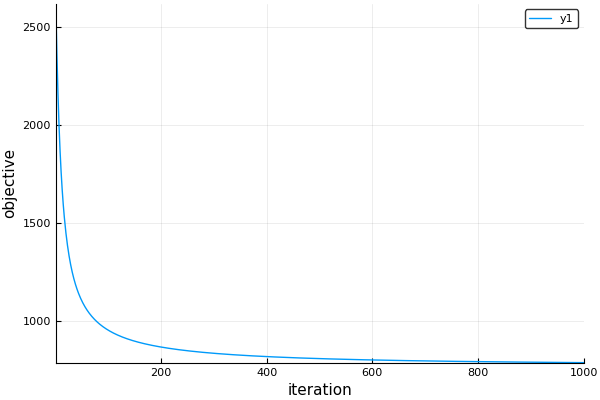

In [66]:
Plots.plot(ch.objective)
xlabel!("iteration")
ylabel!("objective")

In [69]:
y_i2 = Xtest*w

ynew = []
for i in y_i2
    if i > 0
        append!(ynew,1)
    else
        append!(ynew,-1)
    end
end

sum = 0 
for i=1:length(ynew)
    if ynew[i] == ytest[i]
        sum+=1
    end
end
println(sum/length(ynew))

0.9395017793594306


In [75]:
h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree (Julia)",
         "Random Forest (Julia)", "AdaBoost (Julia)", "Naive Bayes", "Linear Discriminant Analysis",
         "Quadratic Discriminant Analysis"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=5, C=4),
    DecisionTreeClassifier(pruning_purity_threshold=0.8),
    RandomForestClassifier(ntrees=30),
    # Note: scikit-learn's adaboostclassifier is better than DecisionTree.jl in this instance
    # because it's not restricted to stumps, and the data isn't axis-aligned
    AdaBoostStumpClassifier(niterations=30),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(), 
];

In [77]:
cvt = cross_val_score(DecisionTreeClassifier(pruning_purity_threshold=0.8), X, y; cv=10)

10-element Array{Float64,1}:
 0.94347 
 0.945419
 0.949318
 0.933723
 0.935673
 0.945419
 0.949219
 0.949219
 0.968689
 0.939335

In [78]:
summarystats(cvt)

Summary Stats:
Mean:           0.945948
Minimum:        0.933723
1st Quartile:   0.940368
Median:         0.945419
3rd Quartile:   0.949219
Maximum:        0.968689


In [79]:
cvt = cross_val_score(RandomForestClassifier(ntrees=30),X,y; cv = 10)

10-element Array{Float64,1}:
 0.957115
 0.951267
 0.951267
 0.94152 
 0.939571
 0.947368
 0.960938
 0.966797
 0.95499 
 0.953033

In [80]:
summarystats(cvt)

Summary Stats:
Mean:           0.952387
Minimum:        0.939571
1st Quartile:   0.948343
Median:         0.952150
3rd Quartile:   0.956584
Maximum:        0.966797


In [82]:
for (name, clf) in zip(names, classifiers)
    fit!(clf, Xtrain, ytrain)
    scor = score(clf, Xtest, ytest)
    println(scor)
end

0.951067615658363
0.9386120996441281
0.7615658362989324
0.9501779359430605
0.9617437722419929
0.9252669039145908
0.9279359430604982
0.9297153024911032
0.9261565836298933


In [83]:
model = build_tree(ytrain, Xtrain)

Decision Tree
Leaves: 300
Depth:  26

In [84]:
model = prune_tree(model, 0.8)

Decision Tree
Leaves: 248
Depth:  21

In [85]:
print_tree(model,5)

Feature 8, Threshold 0
L-> Feature 14, Threshold 1
    L-> Feature 6, Threshold 1
        L-> -1 : 974/974
        R-> Feature 17, Threshold 1
            L-> Feature 10, Threshold 1
                L-> -1 : 63/63
                R-> 
            R-> Feature 27, Threshold 1
                L-> 
                R-> -1 : 313/313
    R-> Feature 31, Threshold 1
        L-> Feature 24, Threshold 1
            L-> -1 : 84/86
            R-> Feature 6, Threshold 1
                L-> 
                R-> 
        R-> Feature 26, Threshold 1
            L-> Feature 7, Threshold 0
                L-> -1 : 50/50
                R-> 
            R-> Feature 6, Threshold 1
                L-> 
                R-> 
R-> Feature 14, Threshold 0
    L-> Feature 6, Threshold 1
        L-> Feature 2, Threshold 1
            L-> Feature 31, Threshold 1
                L-> 
                R-> -1 : 26/26
            R-> -1 : 39/39
        R-> Feature 26, Threshold 0
            L-> Feature 7, Threshold 0

In [86]:
ytree = apply_tree(model, Xtest); #apply model to test data

In [87]:
false_pos = 0
false_neg = 0 
sum = 0 
for i=1:length(ytree)
    if ytest[i] != ytree[i]
        sum+=1
        if (ytest[i] == 1 && ytree[i] == -1)
            false_neg += 1
        else
            false_pos += 1
        end
    end
end
println("false positive: ", false_pos/length(ytree))
println("false negative: ",false_neg/length(ytree))
println("total error ", sum/length(ytree))

false positive: 0.02402135231316726
false negative: 0.025800711743772242
total error 0.0498220640569395


In [88]:
accuracy = nfoldCV_forest(ytrain, Xtrain, 2, 100,3,0.5)


Fold 1
Classes:  

2×2 Array{Int64,2}:
 700   40
  28  565

[-1, 1]
Matrix:   
Accuracy: 0.9489872468117029
Kappa:    0.8969256450959967


2×2 Array{Int64,2}:
 682   46
  31  574


Fold 2
Classes:  [-1, 1]
Matrix:   
Accuracy: 0.9422355588897224
Kappa:    0.8837225636523266


2×2 Array{Int64,2}:
 692   42
  35  564


Fold 3
Classes:  [-1, 1]
Matrix:   
Accuracy: 0.9422355588897224
Kappa:    0.8833992027509523

Mean Accuracy: 0.9444861215303826


3-element Array{Float64,1}:
 0.948987
 0.942236
 0.942236

In [89]:
rf = build_forest(ytrain, Xtrain, 2, 100, 0.5, 50)

Ensemble of Decision Trees
Trees:      100
Avg Leaves: 149.61
Avg Depth:  15.97

In [91]:
yforest = apply_forest(rf, Xtest);

In [92]:
false_pos = 0
false_neg = 0 
sum = 0 
for i=1:length(yforest)
    if ytest[i] != yforest[i]
        sum+=1
        if (ytest[i] == 1 && yforest[i] == -1)
            false_neg += 1
        else
            false_pos += 1
        end
    end
end
println("false positive: ", false_pos/length(yforest))
println("false negative: ",false_neg/length(yforest))
println("total error ", sum/length(yforest))

false positive: 0.02402135231316726
false negative: 0.023131672597864767
total error 0.04715302491103203
